<a href="https://colab.research.google.com/github/RoyElkabetz/Text-Summarization-with-Deep-Learning/blob/main/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## uncomment only if running from google.colab
# clone the git reposetory
!git clone https://github.com/RoyElkabetz/Text-Summarization-with-Deep-Learning
# add path to .py files for import
import sys
sys.path.insert(1, "/content/Text-Summarization-with-Deep-Learning")

Cloning into 'Text-Summarization-with-Deep-Learning'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 53 (delta 28), reused 6 (delta 0), pack-reused 0
Unpacking objects: 100% (53/53), done.


In [1]:
## uncomment if you want to mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%matplotlib inline
import time
import pandas as pd


import torch
from torchtext.datasets import IMDB
import torchtext.data as data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torch import nn




print(f'torch {torch.__version__}')
print('Device properties:')
if torch.cuda.is_available():
    device = torch.device("cuda")
    gpu_data = torch.cuda.get_device_properties(0)
    gpu_name = gpu_data.name
    gpu_mem  = f'{gpu_data.total_memory * 1e-9:.02f} Gb'
    print(f'GPU: {gpu_name}\nMemory: {gpu_mem}')
else:
    device = torch.device("cpu")
    print('CPU')

torch 1.9.0+cu102
Device properties:
GPU: Tesla T4
Memory: 15.84 Gb


In [3]:
class DataFrameDataset(Dataset):
  """Create a torch.utils.data.Dataset from a pandas.DataFrame or a CSV file."""

  def __init__(self, csv_file_path=None, pd_dataframe=None, only_columns=None):
    """
      Args:
      csv_file_path (string): Path to the csv file with annotations.
      pd_dataframe (Pandas DataFrame): A Pandas DataFrame with containing the
      data.
      only_columns (list): A List of colums names from the data. 
    """
    if isinstance(pd_dataframe, pd.DataFrame):
      self.df = pd_dataframe 
    else:
      self.df = pd.read_csv(csv_file_path)

    if only_columns is not None:
      if isinstance(only_columns, list):
        for item in only_columns:
          if item not in self.df.columns:
            raise ValueError(f"Got a column name '{item}' in only_columns which is not in DataFrame columns.")
        self.only_columns = only_columns
      else:
        raise TypeError(f"only_columns must be a <class 'list'>, instead got a {type(only_columns)}.")
    else:
      self.only_columns = list(self.df.columns)

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx][self.only_columns]
    row_list = [item for item in row]
    return row_list

## Get the IMDB dataset and create a vocabulary from the train dataset
I use the IMDB test data as train

In [4]:
tokenizer = get_tokenizer('basic_english')
train_iter = IMDB(split='test')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>", "<sos>", "<eos>"])
vocab.set_default_index(vocab["<unk>"])

aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:01<00:00, 71.4MB/s]


## Create text and labels pipelines

In [5]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: 0 if x=='neg' else 1

## Print some random samples and the size of the dataset

In [6]:
train_iter = IMDB(split='test')
n_samples = len(train_iter)
random_list = torch.randint(0, n_samples - 1, (4, ))
labels = []
for i, (label, text) in enumerate(train_iter):
    labels.append(label)
    if i in random_list:
        print(f'Label: {label_pipeline(label)}')
        print(f'Text: {text}')
        print(f'Split: {tokenizer(text)}')
        print(f'Tokens: {text_pipeline(text)}\n')
print('Number of classes: {}'.format(len(set(labels))))
print('Number of samples: {}'.format(n_samples))

Label: 0
Text: It's been said that some directors make small budget pictures look like blockbusters. Albert Pyun makes small budget pictures look like high school A/V project films. This film was pretty much lacking in all departments. Practically every scene drags on excessively, the "experimental" lighting and camera work is terrible, Rob Lowe apparently equated being scruffy with acting, and the poor drab Euro-pop numbers stop the movie to a dead halt. On the plus side, Burt Reynolds does a pretty good job with what he's given (which isn't much), Mario Van Peebles is surprisingly decent and Ice-T puts in another of a long recent string of B-movie gangsters. Not Pyun's worst work (Urban Menace), but certainly not his best (Mean Guns).
Split: ['it', "'", 's', 'been', 'said', 'that', 'some', 'directors', 'make', 'small', 'budget', 'pictures', 'look', 'like', 'blockbusters', '.', 'albert', 'pyun', 'makes', 'small', 'budget', 'pictures', 'look', 'like', 'high', 'school', 'a/v', 'project'

In [7]:
VALID_DATASET_PATH = '/content/gdrive/MyDrive/Datasets/Text/IMDB_validation_dataset.csv'
TEST_DATASET_PATH = '/content/gdrive/MyDrive/Datasets/Text/IMDB_test_with_summary_dataset.csv'

valid_dataset = DataFrameDataset(csv_file_path=VALID_DATASET_PATH, only_columns=['label', 'text'])
test_dataset = DataFrameDataset(csv_file_path=TEST_DATASET_PATH, only_columns=['label', 'summary'])
full_test_dataset = DataFrameDataset(csv_file_path=TEST_DATASET_PATH, only_columns=['label', 'text', 'summary'])
print(f'Validation dataset size is: {len(valid_dataset)}')
print(f'Test dataset size is: {len(test_dataset)}')

Validation dataset size is: 16434
Test dataset size is: 8467


In [8]:
test_loader = DataLoader(full_test_dataset, batch_size=4, shuffle=True)
for batch in test_loader:
  print('Print samples from a single batch:\n')
  labels, texts, summaries = batch
  for i in range(len(labels)):
    print(f'Label: {label_pipeline(labels[i])}')
    print(f'Text: {texts[i]}')
    print(f'Summary: {summaries[i]}')
    print('\n')
  break

Print samples from a single batch:

Label: 0
Text: In short, the movie had a little bit of a weak 1st act with some forced acting and a somewhat disjointed rhythm and pacing, somewhat of a decent 2nd act that managed to build some tension and intrigue despite some inconsistent pacing and some inferior performances by the cast, and the 3rd act ... there virtually wasn't ANY 3rd act!<br /><br />Regarding the 3rd act, the movie just abruptly ends. There is no resolution and no path down from the climax of the 2nd act, so there wasn't much of a 3rd act. The bad
Summary: The movie had a little bit of a weak 1st act with some forced acting and a disjointed rhythm and pacing, somewhat of a decent 2nd act that managed to build some tension and intrigue despite some inconsistent pacing and some inferior performances by the cast, and the 3rd act... there virtually wasn't ANY 3rd act!


Label: 0
Text: When I saw this "documentary", I was disappointed to see Serbian Propaganda in action once again

In [9]:
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device) 

In [20]:
class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [38]:
num_class = 2
vocab_size = len(vocab)
emsize = 128
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

In [39]:
def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    total_loss = 0
    log_interval = 200
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predited_label = model(text, offsets)
        loss = criterion(predited_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_loss += loss.item()
        total_acc += (predited_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            #total_acc, total_count = 0, 0
            start_time = time.time()
    return total_loss / total_count, total_acc / total_count

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    total_loss = 0
    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predited_label = model(text, offsets)
            loss = criterion(predited_label, label)
            total_loss += loss.item()
            total_acc += (predited_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_loss/total_count, total_acc/total_count

def update_logger(logger, epoch, train_loss, train_acc, valid_loss, valid_acc):
    logger['epochs'].append(epoch)
    logger['train_loss'].append(train_loss)
    logger['train_acc'].append(train_acc)
    logger['valid_loss'].append(valid_loss)
    logger['valid_acc'].append(valid_acc)
    return logger

In [40]:
# Hyperparameters
EPOCHS = 20 # epoch
LR = 5  # learning rate
BATCH_SIZE = 32 # batch size for training
  
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.5)
total_accu = None
train_iter = IMDB(split='test')
train_dataset = to_map_style_dataset(train_iter)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE,
                              shuffle=False, collate_fn=collate_batch)

logger = {'train_loss': [],
          'train_acc': [],
          'valid_loss': [],
          'valid_acc': [],
          'epochs': []}

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_loss, train_acc = train(train_dataloader)
    loss_val, accu_val = evaluate(valid_dataloader)
    logger = update_logger(logger, epoch, train_loss, train_acc, loss_val, accu_val)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
      total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

| epoch   1 |   200/  782 batches | accuracy    0.599
| epoch   1 |   400/  782 batches | accuracy    0.649
| epoch   1 |   600/  782 batches | accuracy    0.682
-----------------------------------------------------------
| end of epoch   1 | time: 13.69s | valid accuracy    0.674 
-----------------------------------------------------------
| epoch   2 |   200/  782 batches | accuracy    0.801
| epoch   2 |   400/  782 batches | accuracy    0.802
| epoch   2 |   600/  782 batches | accuracy    0.809
-----------------------------------------------------------
| end of epoch   2 | time: 13.76s | valid accuracy    0.704 
-----------------------------------------------------------
| epoch   3 |   200/  782 batches | accuracy    0.841
| epoch   3 |   400/  782 batches | accuracy    0.837
| epoch   3 |   600/  782 batches | accuracy    0.838
-----------------------------------------------------------
| end of epoch   3 | time: 13.76s | valid accuracy    0.797 
-------------------------------

In [43]:
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=False, collate_fn=collate_batch)
full_text_test_dataset = DataFrameDataset(csv_file_path=TEST_DATASET_PATH, 
                                          only_columns=['label', 'text'])
full_text_test_dataloader = DataLoader(full_text_test_dataset, 
                                       batch_size=BATCH_SIZE,
                                       shuffle=False, 
                                       collate_fn=collate_batch)

print('Checking the results of full text test dataset.')
loss_full_test, accu_full_test = evaluate(full_text_test_dataloader)
print('Full text test accuracy {:8.3f} and loss {:8.3f}'.format(accu_full_test, loss_full_test))

print('\nChecking the results of summarized text test dataset.')
loss_sum_test, accu_sum_test = evaluate(test_dataloader)
print('Summarized text test accuracy {:8.3f} and loss {:8.3f}'.format(accu_sum_test, loss_sum_test))

Checking the results of full text test dataset.
Full text test accuracy    0.802 and loss    0.015

Checking the results of summarized text test dataset.
Summarized text test accuracy    0.744 and loss    0.022


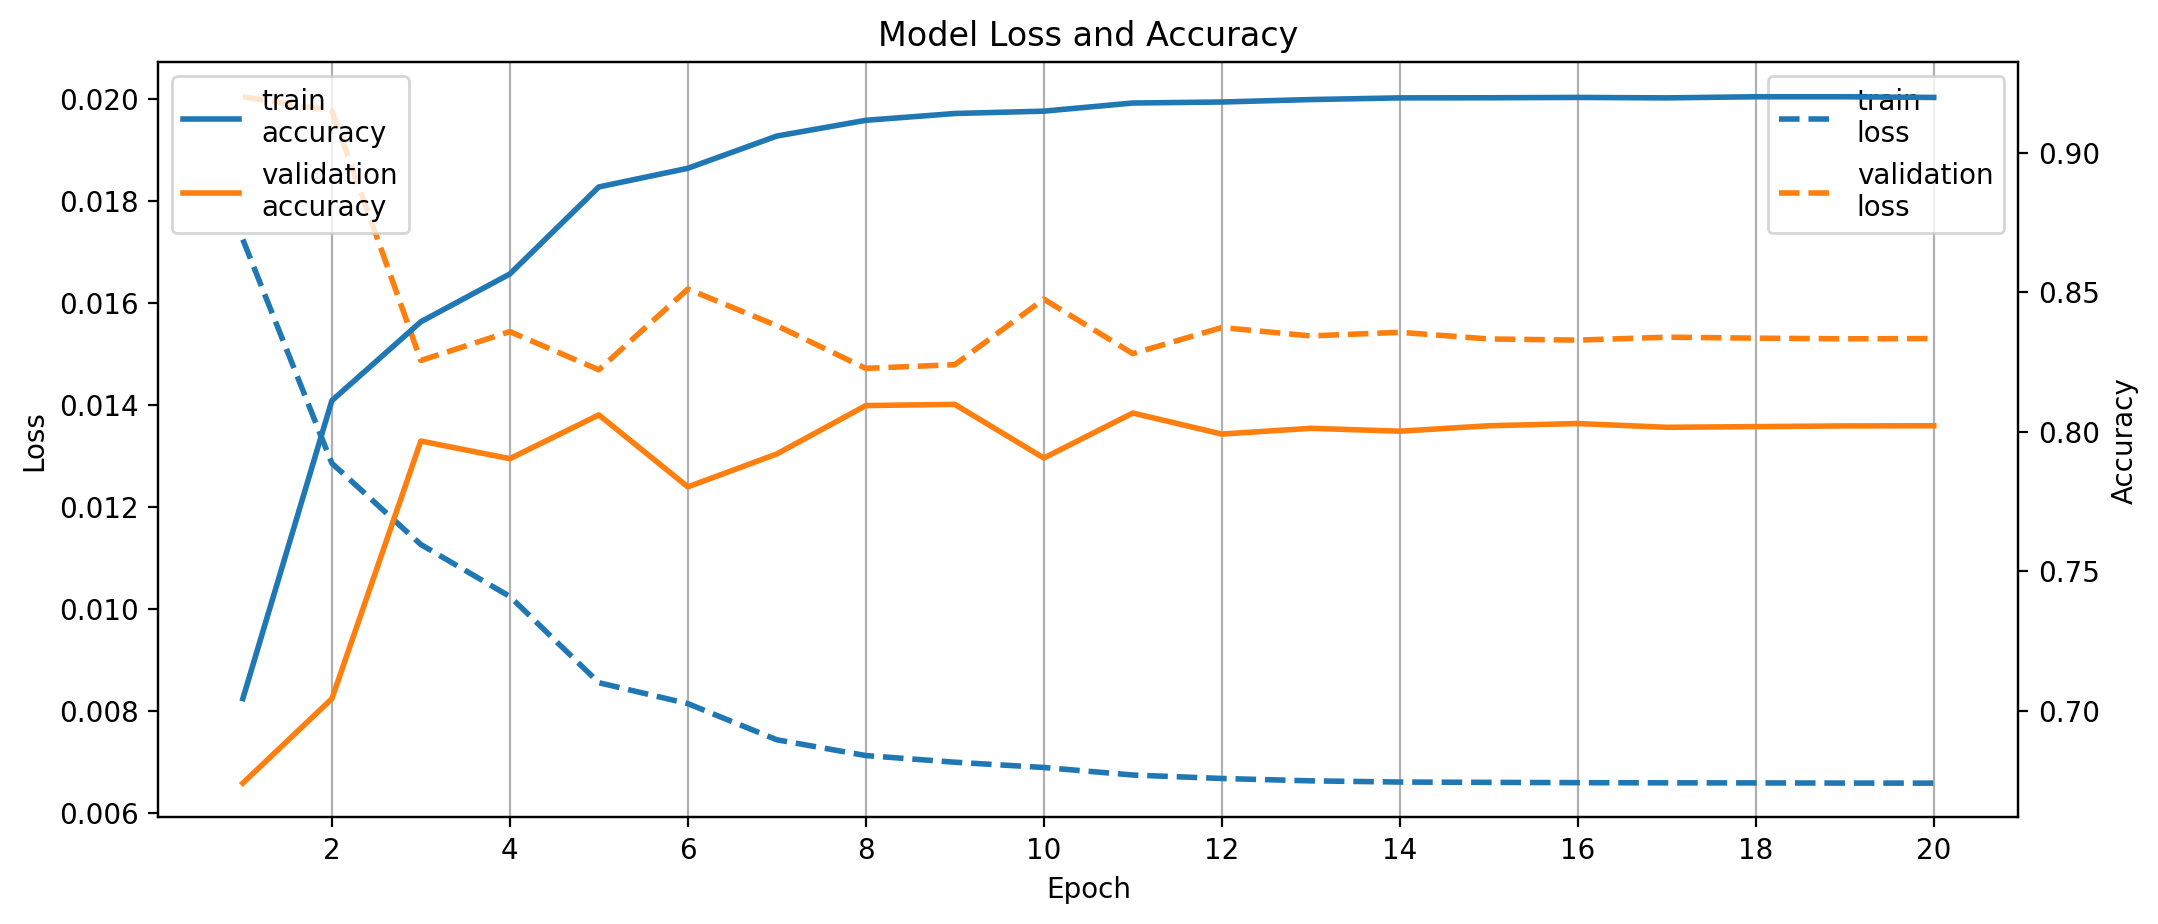

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(12,5), dpi=200)
fig.patch.set_facecolor('white')

# plot accuracy
p1 = ax.plot(logger['epochs'], logger['train_loss'], '--', linewidth=2, label='train\nloss')
p2 = ax.plot(logger['epochs'], logger['valid_loss'], '--', linewidth=2, label='validation\nloss')
ax.set_xticks(range(0, logger['epochs'][-1] + 1, 2))
ax.set_xticklabels(range(0, logger['epochs'][-1] + 1, 2))
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Model Loss and Accuracy')
ax.xaxis.grid()
ax.legend()
ax1 = ax.twinx()
p3 = ax1.plot(logger['epochs'], logger['train_acc'], linewidth=2, label='train\naccuracy')
p4 = ax1.plot(logger['epochs'], logger['valid_acc'], linewidth=2, label='validation\naccuracy')
ax1.set_ylabel('Accuracy')
ax1.legend()

In [46]:
imdb_label = {0: 'negative',
              1: 'positive'}

def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item()

ex_positive_str = "Full of suspense, gripping the entire time, intense, \
  two stories in parallel that come together, somewhat predictable betrayals \
   and twist, felt a bit dark at times, satisfying ending, not a huge amount \
    of action but a solid storyline that keeps you on edge."

ex_negative_str = "This is not your traditional Guy Ritchie movie with slick \
   fast paced action, clever humour and lots of twists. Which I have loved in \
    the past. It is basically a combination of heist movie and revenge \
     thriller. But it's played very straight, without a lot of effort to \
      build characters, and doesn't ever seem to build much momentum. So \
       a few times during the movie I found myself looking at my watch, \
        wondering if it was really going anywhere. The action is fairly \
         tight but mainly gunplay, not much physical action as Statham is \
          famous for. There are no heroes either, Stathams character seems  \
          to be a pretty nasty piece of work himself. All in all, it's an \
           average thriller with nothing in particular to recommend it."

model = model.to("cpu")

print("This is a %s review" %imdb_label[predict(ex_positive_str, text_pipeline)])

This is a positive review
